In [2]:
from numba import vectorize, float64

Let's start with this operation, which shows up a fair bit:

$$(p_{i+1,j}^{n}+p_{i-1,j}^{n})\Delta y^2$$

And notice that we can pass in either $\Delta x$ or $\Delta y$



In [2]:
# @vectorize([float64(float64, float64, float64)], target='parallel')
# def plusminuspar(iplus, iminus, dx):
#     return (iplus + iminus)*dx**2
    

In [3]:
# @vectorize([float64(float64, float64, float64)], target='cpu')
# def plusminus(iplus, iminus, dx):
#     return (iplus + iminus)*dx**2

In [3]:
import numpy

In [5]:
# p = numpy.random.random((400,400))

In [6]:
# a = plusminus(p[1:-1, 2:], p[1:-1, 0:-2], .5)

In [7]:
# b = (p[1:-1, 2:] + p[1:-1, 0:-2])*.5**2

In [8]:
# numpy.allclose(a,b)

True

In [9]:
# %%timeit
# a = plusminus(p[1:-1, 2:], p[1:-1, 0:-2], .5)

The slowest run took 4.78 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 290 µs per loop


In [10]:
# %%timeit
# b = (p[1:-1, 2:] + p[1:-1, 0:-2])*.5**2

The slowest run took 8.01 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 297 µs per loop


Wow, actually a little bit faster than numpy array operations! How about in parallel?

In [11]:
# %%timeit
# a = plusminuspar(p[1:-1, 2:], p[1:-1, 0:-2], .5)

The slowest run took 30.51 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 2.53 ms per loop


Whomp whomp.  Threading overhead is no bueno.  What if it's a bigger problem?

In [12]:
# p = numpy.random.random((1000,1000))

In [13]:
# %%timeit
# a = plusminus(p[1:-1, 2:], p[1:-1, 0:-2], .5)

100 loops, best of 3: 2.4 ms per loop


In [14]:
# %%timeit
# b = (p[1:-1, 2:] + p[1:-1, 0:-2])*.5**2

100 loops, best of 3: 2.71 ms per loop


In [15]:
# %%timeit
# a = plusminuspar(p[1:-1, 2:], p[1:-1, 0:-2], .5)

100 loops, best of 3: 15.9 ms per loop


Yikes

Ok... so vectorize is slightly faster but that parallel target isn't helping.  Maybe if the function is more complicated (just a little bit?)

In [16]:
# @vectorize([float64(float64, float64, float64, float64, float64, float64)], target='cpu')
# def plusminusij(iplus, iminus, jplus, jminus, dx, dy):
#     return ((iplus + iminus)*dy**2 + (jplus + jminus)*dx**2)/(2*(dx**2+dy**2))

In [17]:
# p = numpy.random.random((5000, 5000))

In [18]:
# dx = dy = 0.5
# a = plusminusij(p[1:-1, 2:], p[1:-1, :-2], p[2:, 1:-1], p[:-2, 1:-1], dx, dy)

In [19]:
# b = ((p[1:-1, 2:] + p[1:-1, 0:-2]) * dy**2 + (p[2:, 1:-1] + p[0:-2, 1:-1]) * dx**2) /(2 * (dx**2 + dy**2))

In [20]:
# numpy.allclose(a, b)

True

In [21]:
# %%timeit
# a = plusminusij(p[1:-1, 2:], p[1:-1, :-2], p[2:, 1:-1], p[:-2, 1:-1], dx, dy)

10 loops, best of 3: 120 ms per loop


In [22]:
# %%timeit
# b = ((p[1:-1, 2:] + p[1:-1, 0:-2]) * dy**2 + (p[2:, 1:-1] + p[0:-2, 1:-1]) * dx**2) /(2 * (dx**2 + dy**2))

1 loop, best of 3: 277 ms per loop


In [1]:
# @vectorize([float64(float64, float64, float64, float64, float64, float64)], target='parallel')
# def plusminusijpar(iplus, iminus, jplus, jminus, dx, dy):
#     return ((iplus + iminus)*dy**2 + (jplus + jminus)*dx**2)/(2*(dx**2+dy**2))

NameError: name 'vectorize' is not defined

In [24]:
# %%timeit
# a = plusminusijpar(p[1:-1, 2:], p[1:-1, :-2], p[2:, 1:-1], p[:-2, 1:-1], dx, dy)

1 loop, best of 3: 472 ms per loop


Catching up, but still not great.  How big does it have to be?

In [25]:
# p = numpy.random.random((20000, 20000))

In [26]:
# %%timeit
# a = plusminusij(p[1:-1, 2:], p[1:-1, :-2], p[2:, 1:-1], p[:-2, 1:-1], dx, dy)

1 loop, best of 3: 1.13 s per loop


In [27]:
# %%timeit
# a = plusminusijpar(p[1:-1, 2:], p[1:-1, :-2], p[2:, 1:-1], p[:-2, 1:-1], dx, dy)

1 loop, best of 3: 2.79 s per loop


In [4]:
@vectorize([float64(float64, float64, float64, float64, float64, float64)], target='cpu')
def plusminusij(iplus, iminus, jplus, jminus, dx, dy):
    return (((iplus + iminus) * dy**2 +
            (jplus + jminus) * dx**2) /
            (2 * (dx**2 + dy**2)))

In [5]:
# p1 = numpy.ones((30,30))
# p2 = numpy.ones((30, 30))

# pn = p1.copy()
# p1[1:-1,1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
#                 (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
#                 (2 * (dx**2 + dy**2)))

# p = p2.copy()
# p2[1:-1, 1:-1] = plusminusij(p[1:-1, 2:], 
#             p[1:-1, 0:-2],
#             p[2:, 1:-1],
#             p[0:-2, 1:-1],
#             dx,
#             dy)

# numpy.allclose(p1, p2)

NameError: name 'dy' is not defined

In [30]:
# pran = numpy.random.random((500, 500))

# p1 = pran.copy()
# pn = pran.copy()
# p1[1:-1,1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
#                 (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
#                 (2 * (dx**2 + dy**2)))

# p2 = pran.copy()
# p = pran.copy()
# p2[1:-1, 1:-1] = plusminusij(p[1:-1, 2:], 
#             p[1:-1, 0:-2],
#             p[2:, 1:-1],
#             p[0:-2, 1:-1],
#             dx,
#             dy)

# numpy.allclose(p1, p2)

True

In [6]:
def bracket_term_ppe(b, rho, dt, u, v, dx, dy):
    b[1:-1, 1:-1] = (
        rho * (1 / dt * ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx) +
                         (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                        ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                    2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                         (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx)) -
                        ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2)
                    )

    return b

In [7]:
from numba import njit

In [8]:
@njit
def dirichlet_bc(p):
    J, I = p.shape
    for j in range(J):
        p[j, -1] = p[j, -2]
        p[j, 0] = p[j, 1]
        
    for i in range(I):
        p[0, i] = p[1, i]
        p[-1, i] = 0
        
    return p

In [9]:
@njit
def pressure_poisson(p, dx, dy, b, l2_target=1e-4):
    #pn = p.copy()
    iter_diff = l2_target + 1
    #rho = 1
    while iter_diff > l2_target:
        pn = p.copy()
        p[1:-1,1:-1] = (plusminusij(p[1:-1, 2:], 
                                   p[1:-1, :-2],
                                   p[2:, 1:-1],
                                   p[:-2, 1:-1],
                                   dx,
                                   dy) - 
                        (dx**2 * dy **2 / 
                        (2 * (dx**2 + dy**2))) *
                        b[1:-1, 1:-1])

        p = dirichlet_bc(p)
        J, I = p.shape

        iter_diff = 0
        denom = 0
        
        for j in range(J):
            for i in range(I):
                iter_diff += (p[j, i] - pn[j, i])**2
                denom += pn[j, i]**2
                
        iter_diff = (iter_diff/denom)**.5
        
    return p

In [10]:
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = numpy.empty_like(u)
    vn = numpy.empty_like(v)
    b = numpy.zeros((ny, nx))
    
    u[-1, :] = 1    #set velocity on cavity lid equal to 1

    for n in range(nt):
        un = u.copy()
        vn = v.copy()

        b = bracket_term_ppe(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)

        u[1:-1,1:-1] = (un[1:-1, 1:-1] -
                        un[1:-1,1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1 ] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                        dt / (2 * rho * dx) *
                        (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                        nu * dt *
                        (1 / dx**2 *
                         (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                        1 / dy**2 *
                         (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                        (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                        (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) *
                        (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * dt *
                        (1 / dx**2 *
                         (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        1 / dy**2 *
                         (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] +vn[0:-2, 1:-1])))

        u[:, 0] = 0
        u[:, -1] = 0
        v[:, 0] = 0
        v[:, -1] = 0
        
        u[0, :] = 0
        u[-1, :] = 1    #set velocity on cavity lid equal to 1
        v[0, :] = 0
        v[-1, :] = 0
        
        
        
    return u, v, p

In [16]:
nx = ny = 401
u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.random.random((ny, nx))
b = numpy.zeros((ny, nx))

u[-1,:] = 1

dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
rho = 1
nu = 0.1
dt = .00001

nt = 200


In [17]:
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

In [18]:
from matplotlib import pyplot, cm
%matplotlib inline

In [19]:
x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)
X, Y = numpy.meshgrid(x, y)

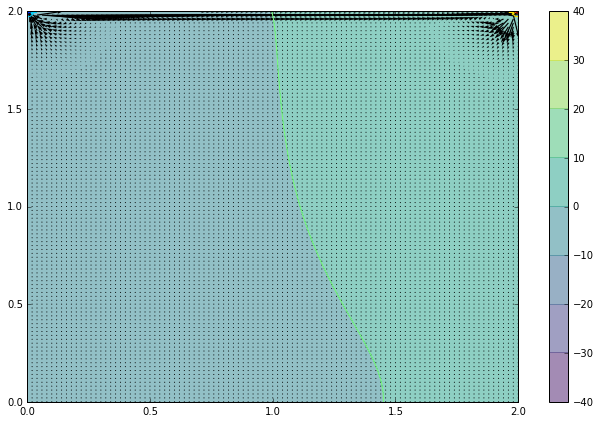

In [20]:
quiver_skip = qs = 4
pyplot.figure(figsize=(11, 7), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p)
pyplot.quiver(X[::qs, ::qs], Y[::qs, ::qs], u[::qs, ::qs], v[::qs, ::qs])

In [34]:
def run_cavity():
    #del u, v, p, b
    nx = ny = 101
    nt = 100
    u = numpy.zeros((ny, nx))
    v = numpy.zeros((ny, nx))
    p = numpy.random.random((ny, nx))
    b = numpy.zeros((ny, nx))    
    #u[-1,:] = 1

    dx = 2 / (nx - 1)
    dy = 2 / (ny - 1)
    rho = 1
    nu = 0.1
    dt = .0005

    nt = 100
    cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

In [35]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [37]:
%lprun -f cavity_flow run_cavity()